# BIBLIOTECAS

In [3]:
# !pip install lifelines

In [4]:
import lifelines as lf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# LEITURA ARQUIVO EQUIPAMENTOS

In [6]:
arquivo = pd.read_csv( 'comparacao.csv', sep= ';')

In [7]:
arquivo.head()

,DATA-INSTALACAO,DATA-RETIRADA,AREA-LOCAL,ANO-FAB,FALHOU?,TECNOLOGIA,MODELO
0,05/10/2011,14/11/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
1,11/04/2011,05/08/2020,UB,2011,NAO FALHOU,ELETROMECANICO,A
2,28/04/2016,30/07/2020,UB,2002,NAO FALHOU,ELETROMECANICO,A
3,26/04/2012,27/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A
4,23/04/2012,13/07/2020,UB,2012,NAO FALHOU,ELETROMECANICO,A


- `DATA-INSTALACAO`: data em que o equipamento foi instalado
- `DATA-RETIRADA`: data em que o equipamento foi retirado
- `AREA-LOCAL`: local em que o equipamento estava instalado (URBANO ou RURAL)
- `ANO-FAB`: ano em que o equipamento foi fabricado
- `FALHOU?`: equipamento falhou ou não.
- `TECNOLOGIA`: tipo do equipamento. ELETRONICO ou ELETROMECANICO
- `MODELO`: modelo ficticio do equipamento

# TRANSFORMAÇÃO

In [21]:
# Verificar se há algum item faltante

arquivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65386 entries, 0 to 65385
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATA-INSTALACAO   65386 non-null  object
 1   DATA-RETIRADA     65386 non-null  object
 2   TIPO-LOCALIZACAO  65386 non-null  object
 3   ANO-FAB           65386 non-null  int64 
 4   DESC-REGIAO       65386 non-null  object
 5   VIDA-UTIL         65386 non-null  int32 
 6   FALHOU?           65386 non-null  object
 7   FALHOU?2          65386 non-null  int64 
 8   TECNOLOGIA        65386 non-null  object
 9   MODELO            65386 non-null  object
dtypes: int32(1), int64(2), object(7)
memory usage: 4.7+ MB


In [16]:
# obter quantos dias o equipamento permaneceu em operação

arquivo['DATA-RETIRADA'] = pd.to_datetime(arquivo['DATA-RETIRADA'])
arquivo['DATA-INSTALACAO'] = pd.to_datetime(arquivo['DATA-INSTALACAO'])

arquivo['VIDA-UTIL'] = (arquivo['DATA-RETIRADA']-arquivo['DATA-INSTALACAO'])/np.timedelta64(1,'D')

arquivo['VIDA-UTIL'] = arquivo['VIDA-UTIL']/365

In [17]:
# transformar os dados da coluna FALHOU? em numérico
# FALHA (FALHOU) = 1 / CENSURA (NAO FALHOU) = 0
arquivo['FALHOU?2'] = 1
arquivo.loc[arquivo['FALHOU?'] == 'NAO FALHOU', 'FALHOU?2'] = 0

# MODELO

In [18]:
# Criação do modelo de Kaplan-Meier

km_fitter = lf.KaplanMeierFitter()

In [22]:
arquivo[['MODELO','TECNOLOGIA']].value_counts()

MODELO  TECNOLOGIA    
A       ELETROMECANICO    48028
D       ELETRONICO         7839
C       ELETROMECANICO     5780
B       ELETRONICO         3739
dtype: int64

O modelo A possui um tempo médio de vida de 12.3 anos


O modelo B possui um tempo médio de vida de 9.5 anos


O modelo C possui um tempo médio de vida de 15.9 anos


O modelo D possui um tempo médio de vida de 5.1 anos




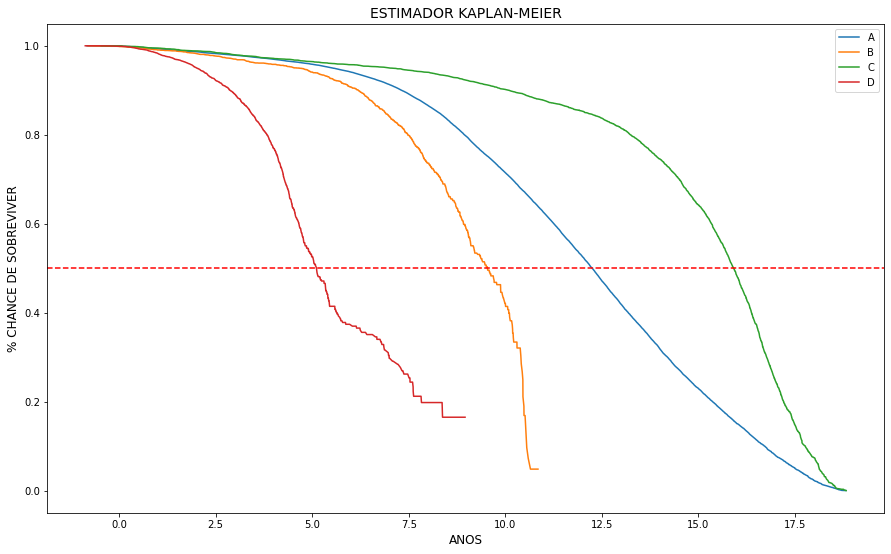

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(15,9))
for i in arquivo['MODELO'].unique():
    tempo = arquivo['VIDA-UTIL'].loc[arquivo['MODELO'] == i]
    evento = arquivo['FALHOU?2'].loc[arquivo['MODELO'] == i]
    
    km_fitter.fit(tempo, event_observed = evento, label = i)
    km_fitter.survival_function_.plot(ax = axes)
    axes.set_title('ESTIMADOR KAPLAN-MEIER',fontsize = 14)
    axes.set_xlabel('ANOS', fontsize = 12)
    axes.set_ylabel('% CHANCE DE SOBREVIVER', fontsize = 12)
    
    print('O modelo {} possui um tempo médio de vida de {} anos\n\n'.format(i,round(km_fitter.median_survival_time_,1)))
axes.axhline(0.5, color = 'red', linestyle = '--')
plt.show()